In [1]:
from cyecca import lie
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pathlib

$\dot{x} = u \cos(\theta)$

$\dot{y} = u \sin(\theta)$

$\dot{\theta} = \dfrac{u}{l} \tan{\delta}$

In [2]:
# define symbols
x = ca.SX.sym("x")  # x position in world frame of rear axle (north)
y = ca.SX.sym("y")  # y position in world frame of rear axle (east)
theta = ca.SX.sym("theta")  # angular heading in world frame (rotation about down)
u = ca.SX.sym("u")  # forward velocity, along body x
delta = ca.SX.sym("delta")  # steering angle, positive rotation about body down
l = ca.SX.sym("l")  # length between rear wheel and front wheels
dt = ca.SX.sym("dt")  # time stemp

In [3]:
G = lie.SE2
X = G.elem(ca.vertcat(x, y, theta))
X.to_Matrix()

SX(@1=cos(theta), @2=sin(theta), 
[[@1, (-@2), x], 
 [@2, @1, y], 
 [00, 00, 1]])

In [4]:
omega = u / l * ca.tan(delta)
v = G.algebra.elem(ca.vertcat(u, 0, omega))
v.to_Matrix()

<class 'casadi.casadi.SX'>


SX(@1=((u/l)*tan(delta)), 
[[00, (-@1), u], 
 [@1, 00, 0], 
 [00, 00, 00]])

In [5]:
G.algebra.elem(ca.vertcat(0, 0, 0)).exp(G)

SE2LieGroup: SX(@1=0, [@1, @1, @1])

In [6]:
v.exp(G)

SE2LieGroup: SX(@1=((u/l)*tan(delta)), @2=1e-07, @3=(fabs(@1)<@2), @4=1, @5=(fabs(@1)<@2), [(((@3?((@4+(-0.166667*sq(@1)))+(0.00833333*sq(sq(@1)))):0)+((!@3)?(sin(@1)/@1):0))*u), (((@5?(((0.5*@1)+(-0.0416667*(@1*sq(@1))))+(0.00138889*(@1*sq(sq(@1))))):0)+((!@5)?((@4-cos(@1))/@1):0))*u), @1])

In [7]:
X1 = X + v
f_predict = ca.Function(
    "predict",
    [X.param, delta, u, l],
    [X1.param],
    ['x0', 'delta', 'u', 'l'],
    ['x1']
)

In [8]:
def simulate():
    x = np.array([0, 0, 0])
    l = 0.225
    dt = 0.01
    tf = 10
    data = {
        "t": [],
        "x": [],
        "u": [],
        "delta": [],
    }
    for t in np.arange(0, tf, dt):
        data["t"].append(np.array(t))
        data["x"].append(x)
        u = np.sin(2 * np.pi * 2 * 0.4 * t)*dt
        delta = np.cos(2 * np.pi * 0.1 * t)
        x = np.array(f_predict(x, delta, u, l)).reshape(-1)

    for k in data.keys():
        data[k] = np.array(data[k])

    return data


data = simulate()

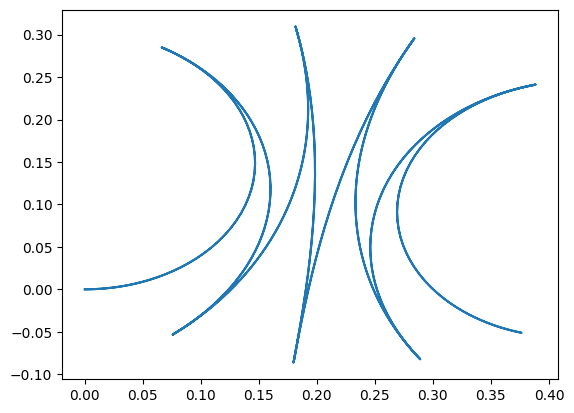

In [9]:
plt.plot(data["x"][:, 0], data["x"][:, 1], "-")

In [10]:
eqs = {
    'rover2d': {
        'predict': f_predict
    }
}

In [11]:
from pathlib import Path

def generate_code(eqs: dict, dest_dir: str, **kwargs):
    dest_dir = Path(dest_dir)
    p = {
        "verbose": True,
        "mex": False,
        "cpp": False,
        "main": False,
        "with_header": True,
        "with_mem": False,
        "with_export": False,
        "with_import": False,
        "include_math": True,
        "avoid_stack": True,
    }
    for k, v in kwargs.items():
        assert k in p.keys()
        p[k] = v

    for name, eqs in eqs.items():
        filename = "{:s}.c".format(name)
        gen = ca.CodeGenerator(filename, p)
        for f_name in eqs:
            gen.add(eqs[f_name])

        dest_dir = pathlib.Path(dest_dir)
        dest_dir.mkdir(exist_ok=True)
        
        gen.generate(str(dest_dir) + pathlib.os.sep)

In [12]:
generate_code(eqs, 'gen')